# SPR 2026 - Exploratory Data Analysis

Análise exploratória dos dados de mamografia para classificação BI-RADS.

**Compatível com:** Google Colab / Kaggle Notebooks

In [22]:
# ============================================================
# SETUP - Ambiente e Dados
# ============================================================
import os
import sys

# Verificar Colab PRIMEIRO (mais confiável)
IS_COLAB = 'google.colab' in sys.modules
IS_KAGGLE = os.path.exists('/kaggle/input') and not IS_COLAB

print(f"Ambiente: {'Kaggle' if IS_KAGGLE else 'Colab' if IS_COLAB else 'Local'}")

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    DRIVE_BASE = '/content/drive/MyDrive/SPR_2026_outputs'
    DATA_DIR = f'{DRIVE_BASE}/data'
    OUTPUT_DIR = DRIVE_BASE
    
    # Verificar se dados existem no Drive
    if not os.path.exists(f'{DATA_DIR}/train.csv'):
        print("⚠️ Dados não encontrados no Drive!")
        print("Execute primeiro o notebook 00_download_data.ipynb")
        raise FileNotFoundError(f"Arquivo não encontrado: {DATA_DIR}/train.csv")
elif IS_KAGGLE:
    DATA_DIR = '/kaggle/input/spr-2026-mammography-report-classification'
    OUTPUT_DIR = '/kaggle/working'
else:
    DATA_DIR = '../data'
    OUTPUT_DIR = '../submissions'
    os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"DATA_DIR: {DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

Ambiente: Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_DIR: /content/drive/MyDrive/SPR_2026_outputs/data
OUTPUT_DIR: /content/drive/MyDrive/SPR_2026_outputs


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_colwidth', 200)

## 0. Exploração dos Dados no Drive

Verificando os arquivos disponíveis antes de iniciar a análise.

In [24]:
# Verificar arquivos no diretório de dados
print("📂 Arquivos disponíveis no diretório de dados:")
print("-" * 50)
for f in os.listdir(DATA_DIR):
    filepath = os.path.join(DATA_DIR, f)
    size_mb = os.path.getsize(filepath) / (1024*1024)
    print(f"  📄 {f:30} {size_mb:>8.2f} MB")

print(f"\n📍 Caminhos configurados:")
print(f"  DATA_DIR:   {DATA_DIR}")
print(f"  OUTPUT_DIR: {OUTPUT_DIR}")

📂 Arquivos disponíveis no diretório de dados:
--------------------------------------------------
  📄 submission.csv                     0.00 MB
  📄 test.csv                           0.00 MB
  📄 train.csv                          7.57 MB

📍 Caminhos configurados:
  DATA_DIR:   /content/drive/MyDrive/SPR_2026_outputs/data
  OUTPUT_DIR: /content/drive/MyDrive/SPR_2026_outputs


In [25]:
# Preview rápido dos dados
print("📋 Preview do train.csv:")
train_preview = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), nrows=5)
display(train_preview)

print(f"\n📋 Preview do test.csv:")
test_preview = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), nrows=5)
display(test_preview)

print(f"\n📋 Preview do submission.csv:")
sub_preview = pd.read_csv(os.path.join(DATA_DIR, 'submission.csv'), nrows=5)
display(sub_preview)

📋 Preview do train.csv:


,ID,report,target
0,Acc1,Indicação clínica:\n\r rastreamento.\n\rAchados:\n\rMamas parcialmente lipossubstituídas.\n\rCalcificações benignas esparsas.\n\rNão se observam calcificações suspeitas agrupadas.\n\rAs regiões ax...,2
1,Acc3,Indicação clínica:\n\r rastreamento.\n\rAchados:\n\rMamas parcialmente lipossubstituídas.\n\rCalcificações benignas esparsas.\n\rNão se observam calcificações suspeitas agrupadas.\n\rAs regiões ax...,2
2,Acc5,Indicação clínica:\n\r rastreamento.\n\rAchados:\n\rMamas parcialmente lipossubstituídas.\n\rCalcificações benignas esparsas.\n\rNão se observam calcificações suspeitas agrupadas.\n\rAs regiões ax...,2
3,Acc6,Indicação clínica:\n\r reavaliação de alteração observada à mamografia de <DATA>.\n\rAchados:\n\rCalcificações benignas esparsas.\n\rAssimetria focal localizada no quadrante superolateral da mama ...,2
4,Acc7,"Indicação clínica:\n\r reavaliação de alteração observada à mamografia de <DATA>.\n\rRealizadas incidências cranio-caudal, mediolateral oblíqua e perfil com compressão localizada na mama direita.\...",2



📋 Preview do test.csv:


,ID,report
0,Acc0,"Indicação clínica: rastreamento.Achados:Mamas parcialmente lipossubstituídas.Nódulo irregular localizado no quadrante superolateral da mama direita, medindo 2,8 cm, que à ultrassonografia compleme..."
1,Acc2,Indicação clínica: rastreamento.Achados:Mamas parcialmente lipossubstituídas.Calcificações benignas esparsas.Não se observam calcificações suspeitas agrupadas.As regiões axilares não apresentam al...
2,Acc4,Indicação clínica: rastreamento.Achados:Mamas parcialmente lipossubstituídas.Marcador radiopaco em lesão cutânea à direita.Não se observam calcificações suspeitas agrupadas.As regiões axilares não...
3,Acc10,Indicação clínica: reavaliação de alteração observada à mamografia de <DATA>.Realizadas incidências perfil e craniocaudal compressão localizada na mama direita.Achados:O nódulo observado na união ...



📋 Preview do submission.csv:


,ID,target
0,Acc0,-1
1,Acc2,-1
2,Acc4,-1
3,Acc10,-1
4,Acc11,-1


In [26]:
# Estatísticas rápidas do dataset
train_full = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_full = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

print("=" * 60)
print("📊 RESUMO DO DATASET SPR 2026")
print("=" * 60)
print(f"\n🔹 TRAIN:")
print(f"   Amostras: {len(train_full):,}")
print(f"   Colunas:  {train_full.columns.tolist()}")
print(f"   Target:   {train_full['target'].nunique()} classes (0-6)")

print(f"\n🔹 TEST:")
print(f"   Amostras: {len(test_full):,}")
print(f"   Colunas:  {test_full.columns.tolist()}")

print(f"\n🔹 DISTRIBUIÇÃO DO TARGET:")
for val, count in train_full['target'].value_counts().sort_index().items():
    pct = count / len(train_full) * 100
    bar = "█" * int(pct / 2)
    print(f"   BI-RADS {val}: {count:5,} ({pct:5.1f}%) {bar}")

print(f"\n✅ Dados carregados com sucesso do Google Drive!")

📊 RESUMO DO DATASET SPR 2026

🔹 TRAIN:
   Amostras: 18,272
   Colunas:  ['ID', 'report', 'target']
   Target:   7 classes (0-6)

🔹 TEST:
   Amostras: 4
   Colunas:  ['ID', 'report']

🔹 DISTRIBUIÇÃO DO TARGET:
   BI-RADS 0:   610 (  3.3%) █
   BI-RADS 1:   693 (  3.8%) █
   BI-RADS 2: 15,968 ( 87.4%) ███████████████████████████████████████████
   BI-RADS 3:   713 (  3.9%) █
   BI-RADS 4:   214 (  1.2%) 
   BI-RADS 5:    29 (  0.2%) 
   BI-RADS 6:    45 (  0.2%) 

✅ Dados carregados com sucesso do Google Drive!


## 1. Carregar Dados

In [27]:
# Carregar dados
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
print(f"Train shape: {train.shape}")
print(f"Colunas: {train.columns.tolist()}")

# Test (Code Competition - pode não existir em dev)
test_path = os.path.join(DATA_DIR, 'test.csv')
if os.path.exists(test_path):
    test = pd.read_csv(test_path)
    print(f"Test shape: {test.shape}")
else:
    test = None
    print("test.csv não disponível - existe apenas no runtime de avaliação Kaggle")

Train shape: (18272, 3)
Colunas: ['ID', 'report', 'target']
Test shape: (4, 2)


In [28]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18272 entries, 0 to 18271
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      18272 non-null  object
 1   report  18272 non-null  object
 2   target  18272 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 428.4+ KB


,ID,report,target
0,Acc1,Indicação clínica:\n\r rastreamento.\n\rAchados:\n\rMamas parcialmente lipossubstituídas.\n\rCalcificações benignas esparsas.\n\rNão se observam calcificações suspeitas agrupadas.\n\rAs regiões ax...,2
1,Acc3,Indicação clínica:\n\r rastreamento.\n\rAchados:\n\rMamas parcialmente lipossubstituídas.\n\rCalcificações benignas esparsas.\n\rNão se observam calcificações suspeitas agrupadas.\n\rAs regiões ax...,2
2,Acc5,Indicação clínica:\n\r rastreamento.\n\rAchados:\n\rMamas parcialmente lipossubstituídas.\n\rCalcificações benignas esparsas.\n\rNão se observam calcificações suspeitas agrupadas.\n\rAs regiões ax...,2
3,Acc6,Indicação clínica:\n\r reavaliação de alteração observada à mamografia de <DATA>.\n\rAchados:\n\rCalcificações benignas esparsas.\n\rAssimetria focal localizada no quadrante superolateral da mama ...,2
4,Acc7,"Indicação clínica:\n\r reavaliação de alteração observada à mamografia de <DATA>.\n\rRealizadas incidências cranio-caudal, mediolateral oblíqua e perfil com compressão localizada na mama direita.\...",2


## 2. Distribuição do Target (BI-RADS)

In [29]:
BIRADS_LABELS = {
    0: 'Incompleto', 1: 'Negativo', 2: 'Benigno', 3: 'Provavelmente Benigno',
    4: 'Suspeito', 5: 'Altamente Sugestivo', 6: 'Malignidade Comprovada'
}

target_counts = train['target'].value_counts().sort_index()
print("Distribuição do Target:")
for idx, count in target_counts.items():
    print(f"  {idx} ({BIRADS_LABELS[idx]}): {count} ({count/len(train)*100:.1f}%)")

Distribuição do Target:
  0 (Incompleto): 610 (3.3%)
  1 (Negativo): 693 (3.8%)
  2 (Benigno): 15968 (87.4%)
  3 (Provavelmente Benigno): 713 (3.9%)
  4 (Suspeito): 214 (1.2%)
  5 (Altamente Sugestivo): 29 (0.2%)
  6 (Malignidade Comprovada): 45 (0.2%)


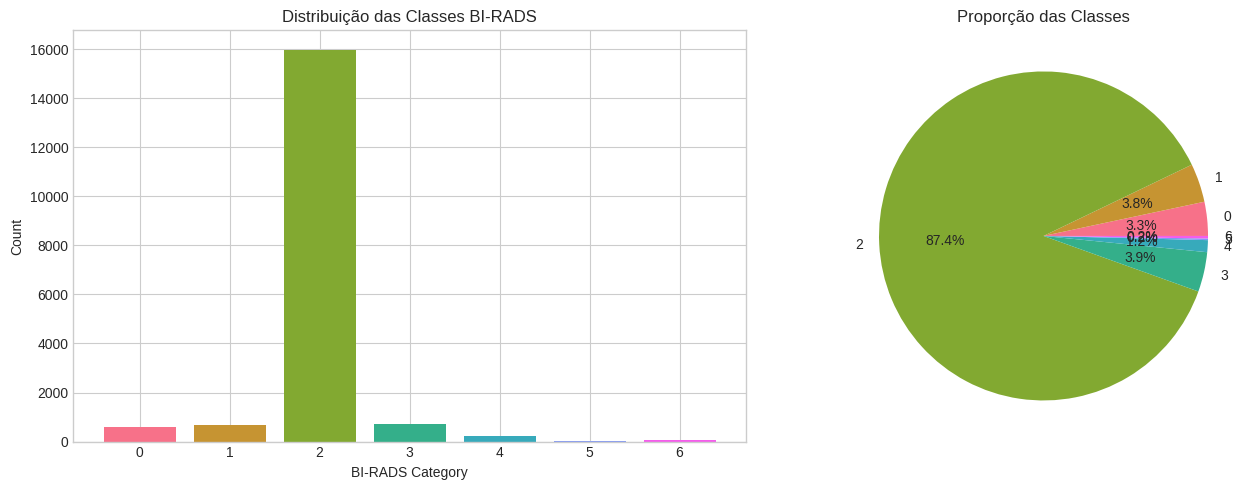

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = sns.color_palette('husl', 7)

axes[0].bar(target_counts.index, target_counts.values, color=colors)
axes[0].set_xlabel('BI-RADS Category')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribuição das Classes BI-RADS')

axes[1].pie(target_counts.values, labels=[f'{i}' for i in target_counts.index], 
            autopct='%1.1f%%', colors=colors)
axes[1].set_title('Proporção das Classes')

plt.tight_layout()
plt.show()

## 3. Análise dos Textos

In [31]:
train['text_length'] = train['report'].apply(len)
train['word_count'] = train['report'].apply(lambda x: len(x.split()))

print("Estatísticas de Comprimento:")
print(train[['text_length', 'word_count']].describe())

Estatísticas de Comprimento:
        text_length    word_count
count  18272.000000  18272.000000
mean     400.666594     44.896618
std      103.232834     14.217563
min      183.000000     19.000000
25%      332.000000     36.000000
50%      364.000000     40.000000
75%      423.000000     48.000000
max     1622.000000    234.000000


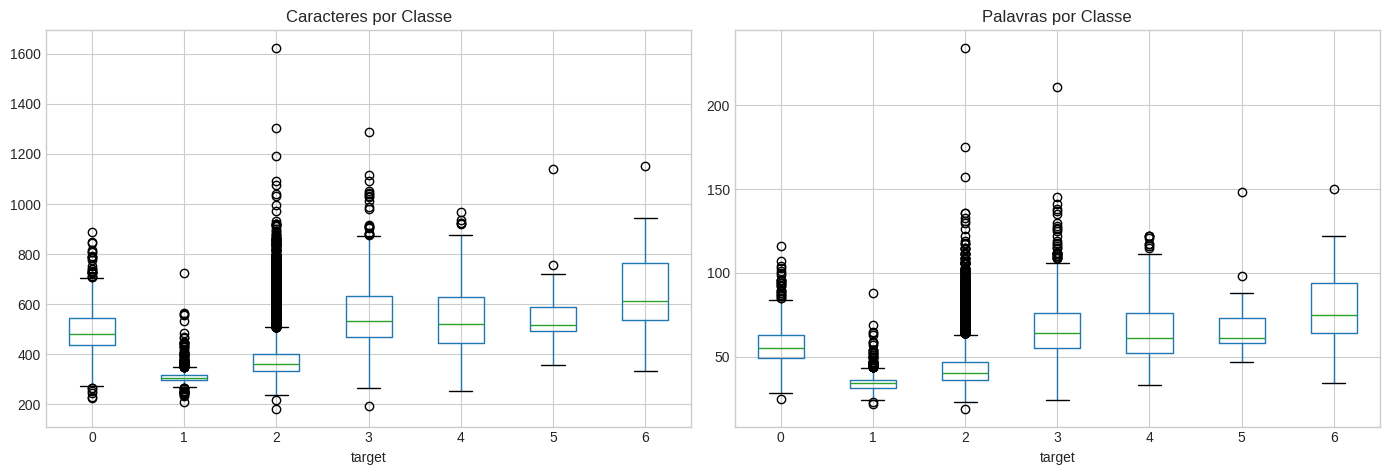

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train.boxplot(column='text_length', by='target', ax=axes[0])
axes[0].set_title('Caracteres por Classe')
train.boxplot(column='word_count', by='target', ax=axes[1])
axes[1].set_title('Palavras por Classe')
plt.suptitle('')
plt.tight_layout()
plt.show()

In [33]:
print("Exemplos de relatórios por classe:")
for target in sorted(train['target'].unique()):
    sample = train[train['target'] == target].iloc[0]
    print(f"\nBI-RADS {target} ({BIRADS_LABELS[target]}):")
    print("-"*40)
    print(sample['report'][:400] + "..." if len(sample['report']) > 400 else sample['report'])

Exemplos de relatórios por classe:

BI-RADS 0 (Incompleto):
----------------------------------------
Indicação clínica:
 reavaliação de alteração observada à mamografia de <DATA>.
Realizadas incidências compressão craniocaudal e perfil ( com compressão localizada) na mama esquerda.
Achados:
Calcificações benignas esparsas.
Assimetria focal localizada no quadrante superolateral da mama esquerda, melhor visualizado na incidência craniocaudal, que muda de configuração nas diversas incidências.
...

BI-RADS 1 (Negativo):
----------------------------------------
Indicação clínica:
 reavaliação de alteração observada à mamografia de <DATA>Realizadas incidências com compressão localizada na mama esquerda.
Achados:
Assimetria focal localizada na projeção dos quadrantes laterais da mama esquerda, que após estudo com compressão seletiva, não evidencia nódulo ou distorção arquitetural, podendo ser caracterizada como área de tecido fibroglandular residual.


BI-RADS 2 (Benigno):
------------------

In [34]:
print("="*60)
print("RESUMO")
print("="*60)
print(f"Amostras: {len(train)} | Classes: {train['target'].nunique()}")
print(f"Palavras média: {train['word_count'].mean():.0f} | Max chars: {train['text_length'].max()}")
print(f"Imbalance ratio: {target_counts.max() / target_counts.min():.1f}x")

RESUMO
Amostras: 18272 | Classes: 7
Palavras média: 45 | Max chars: 1622
Imbalance ratio: 550.6x
